In [2]:
import casadi as ca
import numpy as np
import cvxpy as cp
import control as ct
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import math

### Dynamics
From https://arxiv.org/pdf/1611.09240

$$\begin{align}
\dot{\textbf{p}} &= \textbf{v}\\
\dot{\textbf{v}} &= \frac{1}{m}(\textbf{R}_{IB}\sum_{i=0}^{N_{r}}\textbf{F}_{T,i})+
\begin{bmatrix}
0 \\
0 \\
-g \\
\end{bmatrix}\\
\dot{\textbf{R}}_{IB} &= \textbf{R}_{IB}\lfloor\boldsymbol{\omega}\times\rfloor\\
\textbf{J}\dot{\boldsymbol{\omega}}&=-\boldsymbol{\omega}\times\textbf{J}\boldsymbol{\omega} + \textit{A}
\begin{bmatrix}
n_{1}^{2} \\
\vdots \\
n_{N_{r}}^{2} \\
\end{bmatrix}
\end{align}
$$

More detailed state space model, equivalent to the above from this paper: https://arxiv.org/pdf/2504.13286

We use a NED frame with **intrinsic** Y-P-R rotations ${}^{I}R_{B}=R_{\psi}R_{\theta}R_{\phi}$ with body frame and inertial frames aligned when there is **no rotation**.

$$
\begin{align}
m\ddot{X} &= -F(\cos{\phi}\sin{\theta}\cos{\psi}+\sin{\phi}\sin{\psi}) \\
m\ddot{Y} &= -F(\cos{\phi}\sin{\theta}\sin{\psi}-\sin{\phi}\cos{\psi}) \\
m\ddot{Z} &= -F(\cos{\phi}\cos{\theta})+mg \\
I_{x}\ddot{\phi} &= T_{x}l+\dot{\theta}\dot{\psi}(I_{y}-I_{z}) \\
I_{y}\ddot{\theta} &= T_{y}l+\dot{\psi}\dot{\phi}(I_{z}-I_{x}) \\
I_{z}\ddot{\psi} &= T_{z}l+\dot{\phi}\dot{\theta}(I_{x}-I_{y}) \\
F & = F_1 + F_2 + F_3 + F_4
\end{align}
$$

#### `TODO` Add noise to the state dynamics

In [107]:
## Dynamics
x = ca.SX.sym("x", 12)
u = ca.SX.sym("u", 4)

m = 1  # kg
g = 9.81  # m/s^2
Ix, Iy, Iz = 0.11, 0.11, 0.04  # kg m^2
l = 0.2  # m (this drops out when controlling via torques)
dt=0.01 ## Simulate step at 100Hz

parms = {"Q": np.eye(12), "R": np.eye(4), "N": 10, "Qf": np.eye(12), "dynamic": True}

# non linear dynamics
x_x, x_y, x_z, x_phi, x_theta, x_psi, x_dx, x_dy, x_dz, x_dphi, x_dtheta, x_dpsi = ca.vertsplit(x, 1)
u_F, u_Tx, u_Ty, u_Tz = ca.vertsplit(u, 1)

dx_x = x_dx
dx_y = x_dy
dx_z = x_dz
dx_phi = x_dphi
dx_theta = x_dtheta
dx_psi = x_dpsi
dx_dx = -u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
dx_dy = -u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.sin(x_psi) - ca.sin(x_phi)*ca.cos(x_psi))
dx_dz = -u_F/m * ca.cos(x_phi) * ca.cos(x_theta) + g
dx_dphi = 1/Ix * (u_Tx + x_dtheta * x_dpsi*(Iy - Iz))
dx_dtheta = 1/Iy * (u_Ty + x_dpsi*x_dphi*(Iz - Ix))
dx_dpsi = 1/Iz * (u_Tz + x_dphi*x_dtheta*(Ix-Iy))

x_dot = ca.vertcat(dx_x, dx_y, dx_z, dx_phi, dx_theta, dx_psi, dx_dx, dx_dy, dx_dz, dx_dphi, dx_dtheta, dx_dpsi)
f = x_dot
dynamics = ca.Function("quadrotor_dyn", [x, u], [x + dt * x_dot])

# this is continuous or discrete time?
#jac_dyn_x = ca.jacobian(self.x + self.dt * x_dot, self.x)
#jac_dyn_u = ca.jacobian(self.x + self.dt * x_dot, self.u)
#self.jac_dyn_x = ca.Function("jac_dyn_x", [self.x, self.u], [jac_dyn_x])
#self.jac_dyn_u = ca.Function("jac_dyn_u", [self.x, self.u], [jac_dyn_u])

'''Dynamics model follows:
x,y,z            - position (metres)
phi,theta,psi    - rotation (rad)
dx,dy,dz         - velocity (m/s)
dphi,dtheta,dpsi - angular vel (rad/s)

state (x) = [x,y,z,phi,theta,psi,dx,dy,dz,dphi,dtheta,dpsi]
input (u) = [total force, roll torque, pitch torque, yaw torque]

'''
dynamics

## Tests for correct dynamic model (start 20m above ground w +0.2rad pitch and roll and a constant 12N total force)
out = [0, 0, -20, 0.2, 0.2, 0, 0, 0, 0, 0, 0, 0]
u_in = [12, 0, 0, 0]
## 10 Seconds
for i in range(0,1000):
    out = dynamics(out, u_in)
print(out)
assert(out[0]<0) ## Negative x-coordinate with +ve pitch
assert(out[1]>0) ## Positive y-coordinate with +ve roll
assert(out[2]<0) ## Negative z-coordinate with positive net Force in NED frame

[-116.709, 119.082, -105.732, 0.2, 0.2, 0, -23.3651, 23.8403, -17.1637, 0, 0, 0]


### Controller/Planner
We use two sets of cascaded PI controllers, first for the planner waypoint navigation and then to convert desired roll/pitch/yaw angles (and throttle) to motor control outputs.

**Attitude and Altitude Controllers**
- **3x** pi_stabilize_<roll,pitch,yaw> (actually just proportional controllers)
    - roll (4.5, 0, 0, 0)
    - pitch (4.5, 0, 0, 0)
    - yaw (4.5, 0, 0, 0)
- **3x** pid_rate_<roll,pitch,yaw>
    - roll (0.15, 0.1, 0.004, 500)
    - pitch (0.15, 0.1, 0.004, 500)
    - yaw (0.2, 0.02, 0, 800)
- pi_alt_hold
    - (1, 0, 0, 300)
- pid_throttle_rate
    - (6, 0, 0, 300)
- pid_throttle_accel
    - (0.75, 1.5, 0, 500)

**Waypoint Controllers**
- `_pid_pos_<lat, lon>`
    - (1, 0, 0, 0)
- `_pid_rate_<lat, lon>`
    - (1, 0.5, 0, 400)

#### Attitude control
The waypoint planner will update the **controller_desired_alt** parameter (slewing between a max and min climb rate value).

The PID controller calls **get_throttle_althold** with the **controller_desired_alt** which computes **desired_rate**. **get_throttle_rate** then computes the **throttle_accel_target_ef** (constrained between [-32000, 32000]).

The next call to **run_rate_controllers** actually then calls **get_throttle_accel** which computes the output throttle [0,1000] by calling the PI controller **and then adding throttle cruise (450)**.

#### Control Flow from controller output to ESC PWM signal
The roll/pitch attitude controllers output a value between [-5000, 5000] which is effectively a target roll and pitch rate in the body frame. This is set to the RC_Channels **servo_out** variable. Our RC_Channels are configured to RC_CHANNEL_TYPE_ANGLE_RAW. This means that when the motors retrieve the value via **calc_pwm**, we first multiply the **servo_out** by 0.1 and then add it to **radio_trim**. The **radio_trim** variable is set to **1500** and our **servo_out** range is [-5000,5000] so we are effectively scaling it between [1000, 2000].

However, before returning the reading, **calc_pwm** constrains the reading between **radio_min** and **radio_max** which in our case is 1100 and 1900 respectively, so there is some slight clipping.

In [161]:
class Controller:
    '''Simple PI controller class'''
    def __init__(self, p, i, d, imax, title='(PID)', limit_lower=-1e9, limit_upper=1e9, scale_gains=True):
        self.kp = p
        self.ki = i
        self.kd = d
        self.imax = imax

        self.lower = limit_lower
        self.upper = limit_upper

        self.title=title

        self.cumulative_error = 0
        self.error_previous = None

        self.log = {'error': [], 'target': [], 'feedback': [], 'output': []}

        if scale_gains:
            ## Conversions from centi-degrees to radians
            self.kp *= 0.01*math.pi/180
            self.ki *= 0.01*math.pi/180
            self.kd *= 0.01*math.pi/180
            self.imax *= 0.01*math.pi/180

    def _clamp(self, val):
        return min(max(val,self.lower),self.upper)

    def __call__(self, target, feedback, dt):
        feedback = float(feedback)
        
        # Calculate error
        error = target - feedback

        ## TODO Is this the correct D and I term formulations??

        # Calculate D term
        if self.error_previous is not None:
            d_term = error - self.error_previous
        else:
            d_term = 0
        self.error_previous = error

        # Integrate error and check imax breach
        self.cumulative_error += error*dt*self.ki
        if abs(self.cumulative_error)>self.imax:
            self.cumulative_error = self.imax if self.cumulative_error > 0 else -self.imax

        output = self.kp*(error) + self.cumulative_error + (0 if dt==0 else self.kd*d_term/dt)

        ## Constrain output
        output = self._clamp(output)

        self.log['error'].append(float(error))
        self.log['target'].append(float(target))
        self.log['feedback'].append(float(feedback))
        self.log['output'].append(float(output))
        
        return output

    def plot(self, ax, color='blue'):
        ## TODO Add check to see what update rate of this PID controller is

        ## TODO Change this to increments of dt
        t = range(0,len(self.log['error']))
        ax.plot(t, self.log['error'], color='red', label='error', alpha=0.6)
        ax.plot(t, self.log['feedback'], color='purple', label='feedback', alpha=0.6)
        ax.plot(t, self.log['target'], color=color, label='target', alpha=0.6)
        ax.plot(t, self.log['output'], color=color, linestyle='--', label='output', alpha=0.6)
        ax.set_title(self.title)
        ax.grid()
        ax.legend()

        
    def reset_logging(self):
        self.log = {'error': [], 'target': [], 'feedback': [], 'output': []}
        
    def reset(self):
        self.cumulative_error = 0

## Attitude controllers
## Originally, we limit the output between [-18000,18000] in centi-degrees/s but we change to +-3.14159 (rad/s)
pi_stabilize_roll = Controller(4.5, 0, 0, 0, 'pi_stabilize_roll', -math.pi, math.pi)
pi_stabilize_pitch = Controller(4.5, 0, 0, 0, 'pi_stabilize_pitch', -math.pi, math.pi)
## No yaw constrained-output but we limit the input to between +-45deg
pi_stabilize_yaw = Controller(4.5, 0, 0, 0, 'pi_stabilize_yaw')

## Roll,pitch yaw outputs are constrained by +-45deg/s
pid_rate_roll = Controller(0.15, 0.1, 0.004, 500, 'pid_rate_roll', -50*math.pi/180, 50*math.pi/180)
pid_rate_pitch = Controller(0.15, 0.1, 0.004, 500, 'pid_rate_pitch', -50*math.pi/180, 50*math.pi/180)
pid_rate_yaw = Controller(0.2, 0.02, 0, 800, 'pid_rate_yaw', -45*math.pi/180, 45*math.pi/180)

## Limit the althold controller to +-10m/s and throttle
pi_alt_hold = Controller(1, 0, 0, 300, 'pi_alt_hold', -100, 100)
pid_throttle_rate = Controller(6, 0, 0, 300, 'pid_throttle_rate', -320, 320)
pid_throttle_accel = Controller(0.75, 1.5, 0, 500, 'pid_throttle_accel', -500, 500)

## Waypoint controllers
pid_pos_lat = Controller(1, 0, 0, 0, title='pid_pos_lat', scale_gains=False)
pid_pos_lon = Controller(1, 0, 0, 0, title='pid_pos_lon', scale_gains=False)
pid_rate_lat = Controller(1, 0.5, 0, 400, title='pid_rate_lat', scale_gains=False)
pid_rate_lon = Controller(1, 0.5, 0, 400, title='pid_rate_lon', scale_gains=False)

## Array to easily call reset on all controllers
controller_array = [pi_stabilize_roll, pi_stabilize_pitch, pi_stabilize_yaw,
                    pid_rate_roll, pid_rate_pitch, pid_rate_yaw,
                    pi_alt_hold, pid_throttle_rate, pid_throttle_accel,
                    pid_pos_lat, 
                    pid_pos_lon,
                    pid_rate_lat,
                    pid_rate_lon]

### Motor Allocation
This motor allocation is horribly complex and comes from the original ArduCopter-3.1.2 implementation and as such needs to be re-written to match a simpler motor allocation library.

We use the standard formula for relating rotor speed to force with $k_{t}$ estimated anecdotally as $2.05\times10^{-6}$
$$F_{i}=k_{t}\omega^{2}$$
$$k_t{}=2.05\times10^{-6}$$

Similarly, for the yaw torque **TODO Does the arm length need to be taken into account here? May be included as part of the km estimate as length should be the same for all motors assuming a symmetric frame**
$$T_{\psi}=k_{m}\omega^{2}$$
$$k_{m}=0.02k_{t}$$

We also use an approximation that the PWM out signal in the range of [1000,2000] is equal to the rotor speed $\omega_{i}$.

In [162]:
kt = 2.05e-6
km = 0.02*kt

def motor_allocation(roll, pitch, yaw, throttle):
    '''Calculate the motor allocation to each motor with the provided roll, pitch, yaw, and throttle signals
    
    roll  -> [1000, 2000]
    pitch -> [1000, 2000]
    yaw   -> [1050, 1950]
    throttle -> [1100, 1900]'''

    pwm_out_roll = roll*0.1
    pwm_out_pitch = pitch*0.1
    pwm_out_yaw = yaw*0.1
    pwm_out_throttle = int(800*(throttle-150)/1000) ## range between [0,800]

    radio_out_roll  = pwm_out_roll + 1500
    radio_out_pitch = pwm_out_pitch + 1500
    radio_out_yaw   = pwm_out_yaw + 1500
    radio_out_throttle   = pwm_out_throttle + 1100
    
    out_min_pwm = 1230
    out_max_pwm = 1900
    out_mid_pwm = 1565

    rpy_scale = 1

    rpy_out = [0,0,0,0]
    rpy_out[0] = -pwm_out_roll*math.sqrt(2)/2 + pwm_out_pitch*math.sqrt(2)/2
    rpy_out[1] =  pwm_out_roll*math.sqrt(2)/2 - pwm_out_pitch*math.sqrt(2)/2
    rpy_out[2] = -pwm_out_roll*math.sqrt(2)/2 - pwm_out_pitch*math.sqrt(2)/2
    rpy_out[3] =  pwm_out_roll*math.sqrt(2)/2 + pwm_out_pitch*math.sqrt(2)/2
    
    rpy_max = max(rpy_out)
    rpy_min = min(rpy_out)
        
    motor_mid = (rpy_max+rpy_min)/2
    out_best_thr_pwm = min(out_mid_pwm - motor_mid,
                           max(radio_out_throttle, (radio_out_throttle+500)/2))

    yaw_allowed = max(min(out_max_pwm - out_best_thr_pwm, out_best_thr_pwm - out_min_pwm) - (rpy_max-rpy_min)/2,
                      200)

    if (yaw_allowed>pwm_out_yaw):
        yaw_allowed = pwm_out_yaw
    elif (yaw_allowed<pwm_out_yaw):
        yaw_allowed = pwm_out_yaw

    rpy_out[0] += yaw_allowed
    rpy_out[1] += yaw_allowed
    rpy_out[2] -= yaw_allowed
    rpy_out[3] -= yaw_allowed

    thr_adj = radio_out_throttle - out_best_thr_pwm

    thr_adj_max = max(out_max_pwm - (out_best_thr_pwm+rpy_max),0)

    if thr_adj>thr_adj_max:
        thr_adj = thr_adj_max
    elif thr_adj<0:
        thr_adj_min = min(out_min_pwm - (out_best_thr_pwm+rpy_min),0)
        if thr_adj > thr_adj_max:
            thr_adj = thr_adj_max
        if thr_adj < thr_adj_min:
            thr_adj = thr_adj_min

    if (rpy_min + out_best_thr_pwm) + thr_adj < out_min_pwm:
        if rpy_min==0:
            rpy_scale = 1
        else:
            rpy_scale = ( out_min_pwm - thr_adj - out_best_thr_pwm) / rpy_min
    elif (rpy_max + out_best_thr_pwm) + thr_adj > out_max_pwm:
        if rpy_max==0:
            rpy_scale = 1
        else:
            rpy_scale = ( out_max_pwm - thr_adj - out_best_thr_pwm) / rpy_max

    motor_out = [None, None, None, None]
    for i in range(0,4):
        motor_out[i] = clamp(out_best_thr_pwm + thr_adj  + rpy_scale*rpy_out[i], out_min_pwm, out_max_pwm)

    return motor_out

In [167]:
## Simulation Setup
#iterations = 10*100
iterations=1000

dt = 0.01
x_bag = np.zeros((12, iterations))
time = np.linspace(0,1,100)

temp_x = [0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]
temp_u = [0, 0, 0, 0]

prev_dz_meas = 0.0

def clamp(val, amin, amax):
    return min(max(val,amin),amax)

## Control variables

# Destination (NED frame, metres)
target_x = 50
target_y = 50
target_z = -20 ## Indicates 20 metres above "ground" or "0 alt"
target_yaw = 0 ## No yawing required for our waypoint controller

# Feed forward velocity variables
prev_desired_vel_x = None
prev_desired_vel_y = None

# Output of waypoint planner
desired_roll = None
desired_pitch = None

## Reset all PID controllers
for c in controller_array:
    c.reset()
    c.reset_logging()

## Flag if we are just running the controllers
run_waypoint = False

## Intermediate variables that we want to plot
ctx = {
    'c_roll_out': [],
    'c_pitch_out': [],
    'c_yaw_out': [],
    'c_throttle_out': [],
    'mot_0': [],
    'mot_1': [],
    'mot_2': [],
    'mot_3': [],
    'u_force': [],
    'u_rtorque': [],
    'u_ptorque': [],
    'u_ytorque': []
}

## 1 second simulation
for j in range(0,iterations):
    ## 1. Run waypoint planner (at 25Hz)
    if j%4==0:
        desired_vel_x = pid_pos_lat(target_x, temp_x[0], dt*4)
        desired_vel_y = pid_pos_lon(target_y, temp_x[1], dt*4)

        ## NOTE 'target vel' is fed-forward here
        desired_accel_x = pid_rate_lat(desired_vel_x, temp_x[3], dt*4)
        desired_accel_y = pid_rate_lon(desired_vel_y, temp_x[4], dt*4)

        ## Feed forward an estimate of desired_accel based on previous desired velocities
        desired_accel_x += (desired_vel_x - prev_desired_vel_x)*dt*4 if prev_desired_vel_x is not None else 0
        desired_accel_y += (desired_vel_y - prev_desired_vel_y)*dt*4 if prev_desired_vel_y is not None else 0
        prev_desired_vel_x = desired_vel_x
        prev_desired_vel_y = desired_vel_y

        ## Convert NED (inertial) frame desired accelerations to body frame (to match roll/pitch)
        ## NOTE temp_x[5] is yaw state
        desired_accel_x_body = math.cos(temp_x[5])*desired_accel_x + math.sin(temp_x[5])*desired_accel_y
        desired_accel_y_body = math.cos(temp_x[5])*desired_accel_x - math.sin(temp_x[5])*desired_accel_y

        ## Convert desired accelerations ot desired roll/pitch for attitude controller
        ## NOTE roll impacts the y-body-accel and pitch impacts the x-body-accel
        desired_roll = math.atan2(desired_accel_y_body, g)
        ## TODO Do we need to add another rotation here? Are roll/pitch intrinsic or extrinsic rotations?
        desired_pitch = math.atan2(desired_accel_x_body, g)

    ## Ignore the waypoint planner if we are just testing/tuning the controller
    if not run_waypoint:
        ## 10 degrees of roll and pitch (units are rad)
        desired_roll = 0 #10*math.pi/180
        desired_pitch = 0 #10*math.pi/180
        
    ## 2. Run controller (at 100Hz)
    desired_rate_roll = pi_stabilize_roll(desired_roll, temp_x[3], dt)
    desired_rate_pitch = pi_stabilize_pitch(desired_pitch, temp_x[4], dt)
    
    # NOTE I think these are target roll rates that this controller is trying to drive
    # r<roll,pitch>_output are both constrained between [-5000, 5000]
    # ryaw_output is constrained between [-4500, 4500]
    rroll_output = pid_rate_roll(desired_rate_roll, temp_x[9], dt)
    rpitch_output = pid_rate_pitch(desired_rate_pitch, temp_x[10], dt)

    ## YAW Control
    # Limit the error to be between +-pi/4
    if target_yaw - temp_x[5] > math.pi/4:
        target_yaw = temp_x[5] + math.pi/4
    elif target_yaw - temp_x[5] < math.pi/4:
        target_yaw = temp_x[5] - math.pi/4
        
    desired_rate_yaw = pi_stabilize_yaw(target_yaw, temp_x[5], dt)
    ryaw_output = pid_rate_yaw(desired_rate_yaw, temp_x[11], dt)
    #ryaw_output = clamp(ryaw_output, -4500, 4500)
    
    ## THROTTLE Control
    ## NOTE These are both P-controllers so dt is ignored
    desired_throttle_rate = pi_alt_hold(target_z, temp_x[2], 0)
    desired_throttle_accel = pid_throttle_rate(desired_throttle_rate, temp_x[8], 0)
    #desired_throttle_accel = clamp(desired_throttle_accel, -32000, 32000)

    ## NOTE In this model, we don't explictly have the IMU reading so we don't have dd-z (z-accel) so
    ## we instead use an approx w 3 previous velocity measurements
    accel_estimate = (temp_x[8]-prev_dz_meas)/dt
    rthrottle_output = pid_throttle_accel(desired_throttle_accel, accel_estimate, dt)

    ## NOTE We have changed this from the original ArduCopter code
    rthrottle_output -= 450
    rthrottle_output *= -1

    ## 3. Convert controller to motor outputs
    allocations = motor_allocation(rroll_output, rpitch_output, ryaw_output, rthrottle_output)

    ## 4. Convert to input (force and torques) and feed to dynamics (via temp_u)
    ## NOTE allocations should each be in range [1230, 1900] and we collectively convert to a force/torque

    u_force = 0
    for i in range(0,4):
        u_force += kt*allocations[i]**2

    u_rollt = -l*(math.sqrt(2)/2)*kt*allocations[0]**2 - l*(math.sqrt(2)/2)*kt*allocations[2]**2 + l*(math.sqrt(2)/2)*kt*allocations[1]**2 + l*(math.sqrt(2)/2)*kt*allocations[3]**2
    u_pitcht = l*(math.sqrt(2)/2)*kt*allocations[0]**2 - l*(math.sqrt(2)/2)*kt*allocations[2]**2 - l*(math.sqrt(2)/2)*kt*allocations[1]**2 + l*(math.sqrt(2)/2)*kt*allocations[3]**2

    u_yawt = 0
    for i in range(0,4):
        ## First two motors have -ve yaw-factor and last two have +ve yaw-factor
        ## TODO Check this is correct for yaw contribution
        if i in [0,1]:
            u_yawt += km*allocations[i]**2
        if i in [3,4]:
            u_yawt -= km*allocations[i]**2

    temp_u = [u_force, u_rollt, u_pitcht, u_yawt]

    # Store intermediate variables
    ctx['c_roll_out'].append(rroll_output)
    ctx['c_pitch_out'].append(rpitch_output)
    ctx['c_yaw_out'].append(ryaw_output)
    ctx['c_throttle_out'].append(rthrottle_output)
    ctx['mot_0'].append(allocations[0])
    ctx['mot_1'].append(allocations[1])
    ctx['mot_2'].append(allocations[2])
    ctx['mot_3'].append(allocations[3])
    ctx['u_force'].append(u_force)
    ctx['u_rtorque'].append(u_rollt)
    ctx['u_ptorque'].append(u_pitcht)
    ctx['u_ytorque'].append(u_yawt)

    # Feed dynamics
    prev_dz_meas = temp_x[8]
    temp_x = dynamics(temp_x, temp_u)

    # Record output for plotting
    x_bag[:, j] = temp_x.full().reshape((12,))
    temp_x = temp_x.full().reshape((12,))

print(temp_x, temp_u)

[-2.76072381e-14 -1.87286586e-14 -2.34355207e+02  1.83704966e-15
  1.67026670e-16  9.17955774e+01 -4.94821725e-15 -5.30844521e-15
 -4.89197417e+01  5.62668592e-15 -1.84204815e-14  1.83774642e+01] [np.float64(14.701952200000076), np.float64(1.1102230246251565e-16), np.float64(0.0), np.float64(0.07350972933459422)]


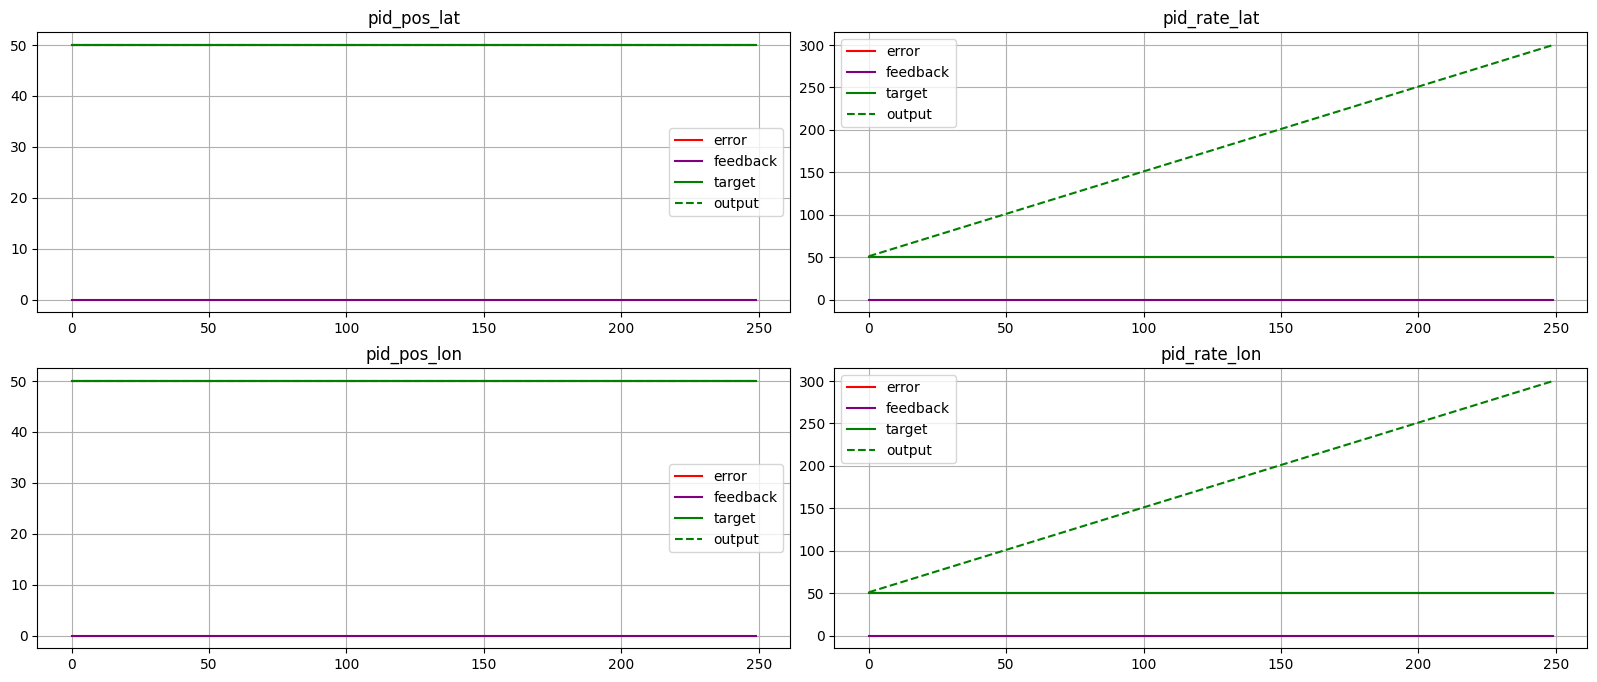

In [147]:
# Visualization - Waypoint Planner
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 6, figure=fig)

# Top plot spans all three columns
pid_pos_lat.plot(fig.add_subplot(gs[0, 0:3]), color='green')
pid_pos_lon.plot(fig.add_subplot(gs[1, 0:3]), color='green')
pid_rate_lat.plot(fig.add_subplot(gs[0, 3:6]), color='green')
pid_rate_lon.plot(fig.add_subplot(gs[1, 3:6]), color='green')
plt.show()

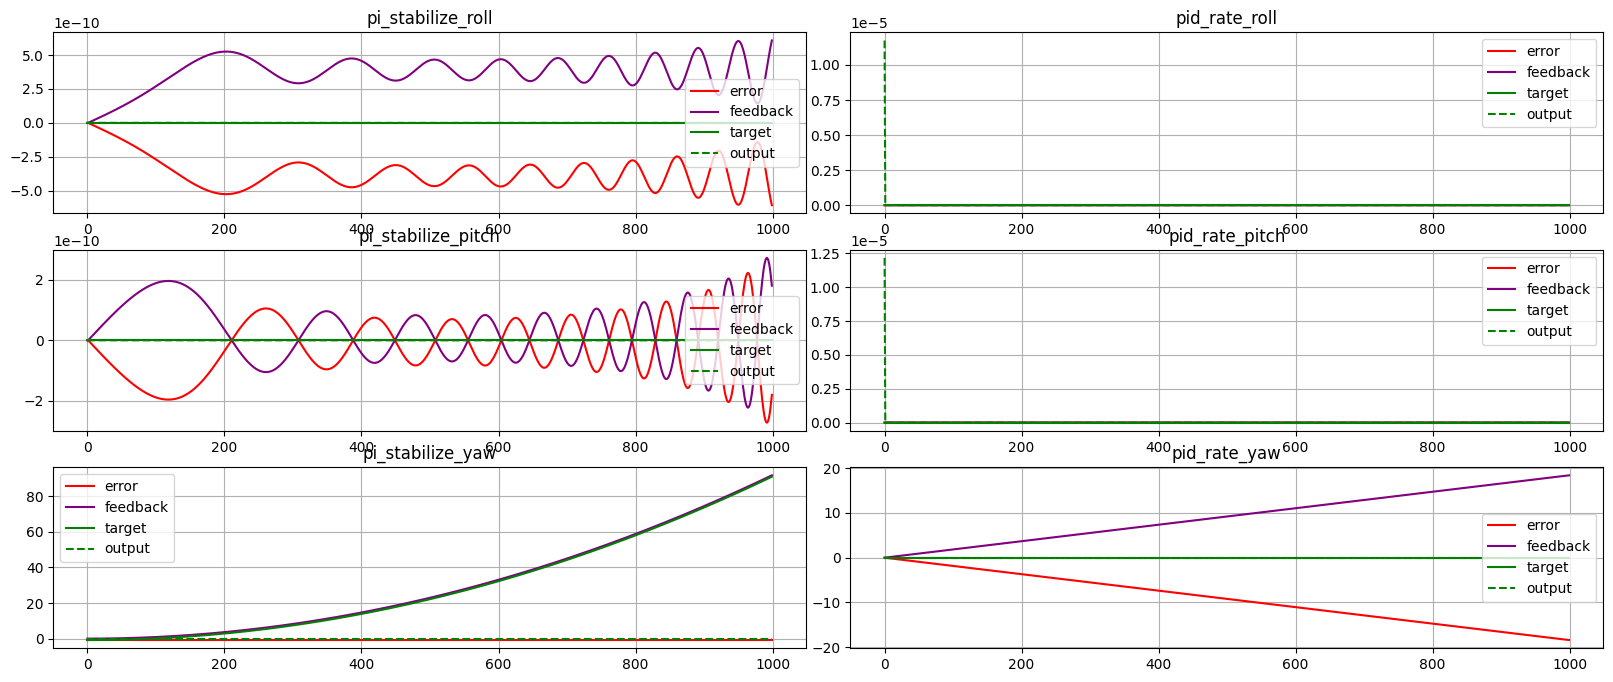

In [148]:
# Visualization - Controller
'''
3 plots for pi_stabilize_<roll, pitch, yaw>
'''
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(3, 6, figure=fig)

# Top plot spans all three columns
pi_stabilize_roll.plot(fig.add_subplot(gs[0, 0:3]), color='green')
pi_stabilize_pitch.plot(fig.add_subplot(gs[1, 0:3]), color='green')
pi_stabilize_yaw.plot(fig.add_subplot(gs[2, 0:3]), color='green')

pid_rate_roll.plot(fig.add_subplot(gs[0, 3:6]), color='green')
pid_rate_pitch.plot(fig.add_subplot(gs[1, 3:6]), color='green')
pid_rate_yaw.plot(fig.add_subplot(gs[2, 3:6]), color='green')

plt.show()

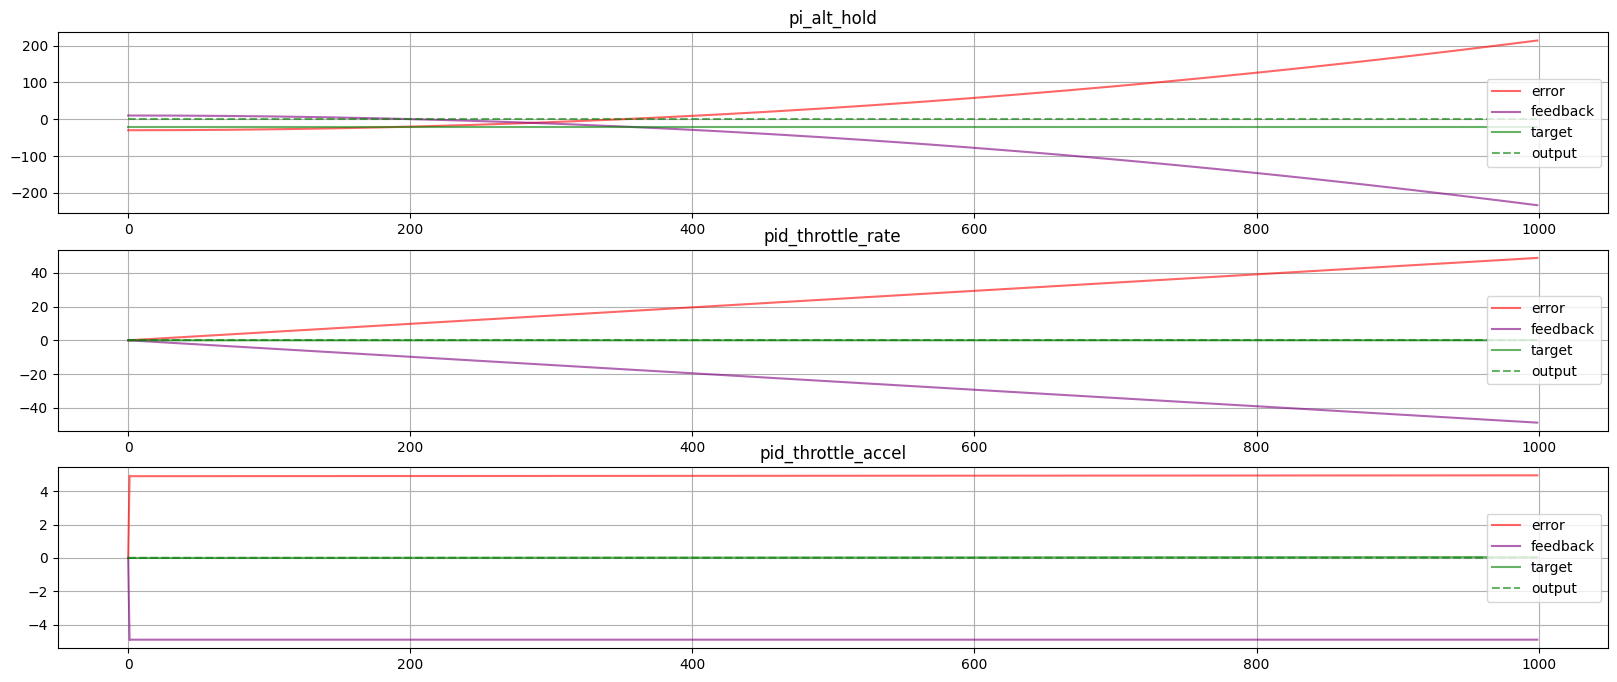

In [168]:
# Visualisation - Throttle
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(3, 1, figure=fig)

# Top plot spans all three columns
pi_alt_hold.plot(fig.add_subplot(gs[0, 0]), color='green')
pid_throttle_rate.plot(fig.add_subplot(gs[1, 0]), color='green')
pid_throttle_accel.plot(fig.add_subplot(gs[2, 0]), color='green')

plt.show()

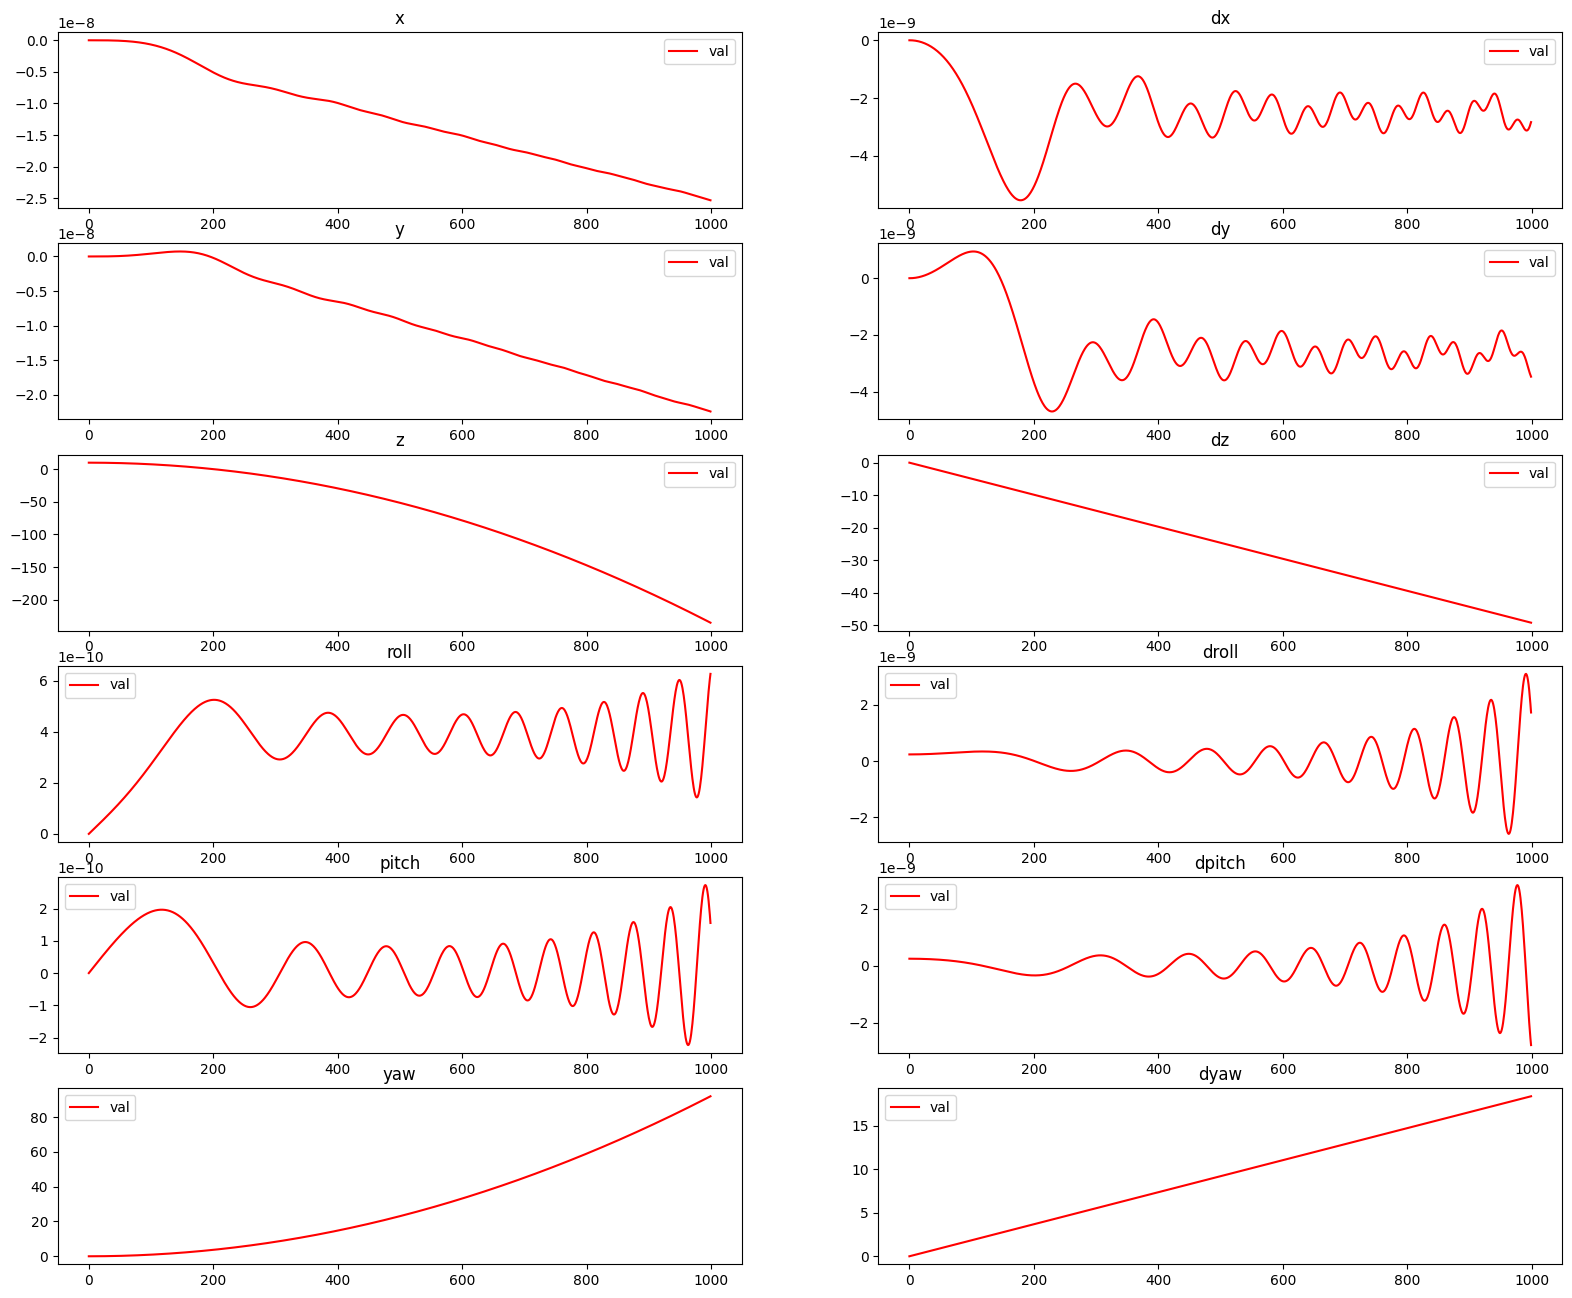

In [151]:
# Visualisation - State Variables
fig = plt.figure(figsize=(30, 16))
gs = GridSpec(6, 3, figure=fig)

for i,title in enumerate(['x','y','z','roll','pitch','yaw','dx','dy','dz','droll','dpitch','dyaw']):
    ax = fig.add_subplot(gs[i%6,i//6])
    t = range(0,x_bag[i,:].shape[0])
    ax.plot(t, x_bag[i,:], color='red', label='val')
    ax.set_title(title)
    ax.legend()

plt.show()

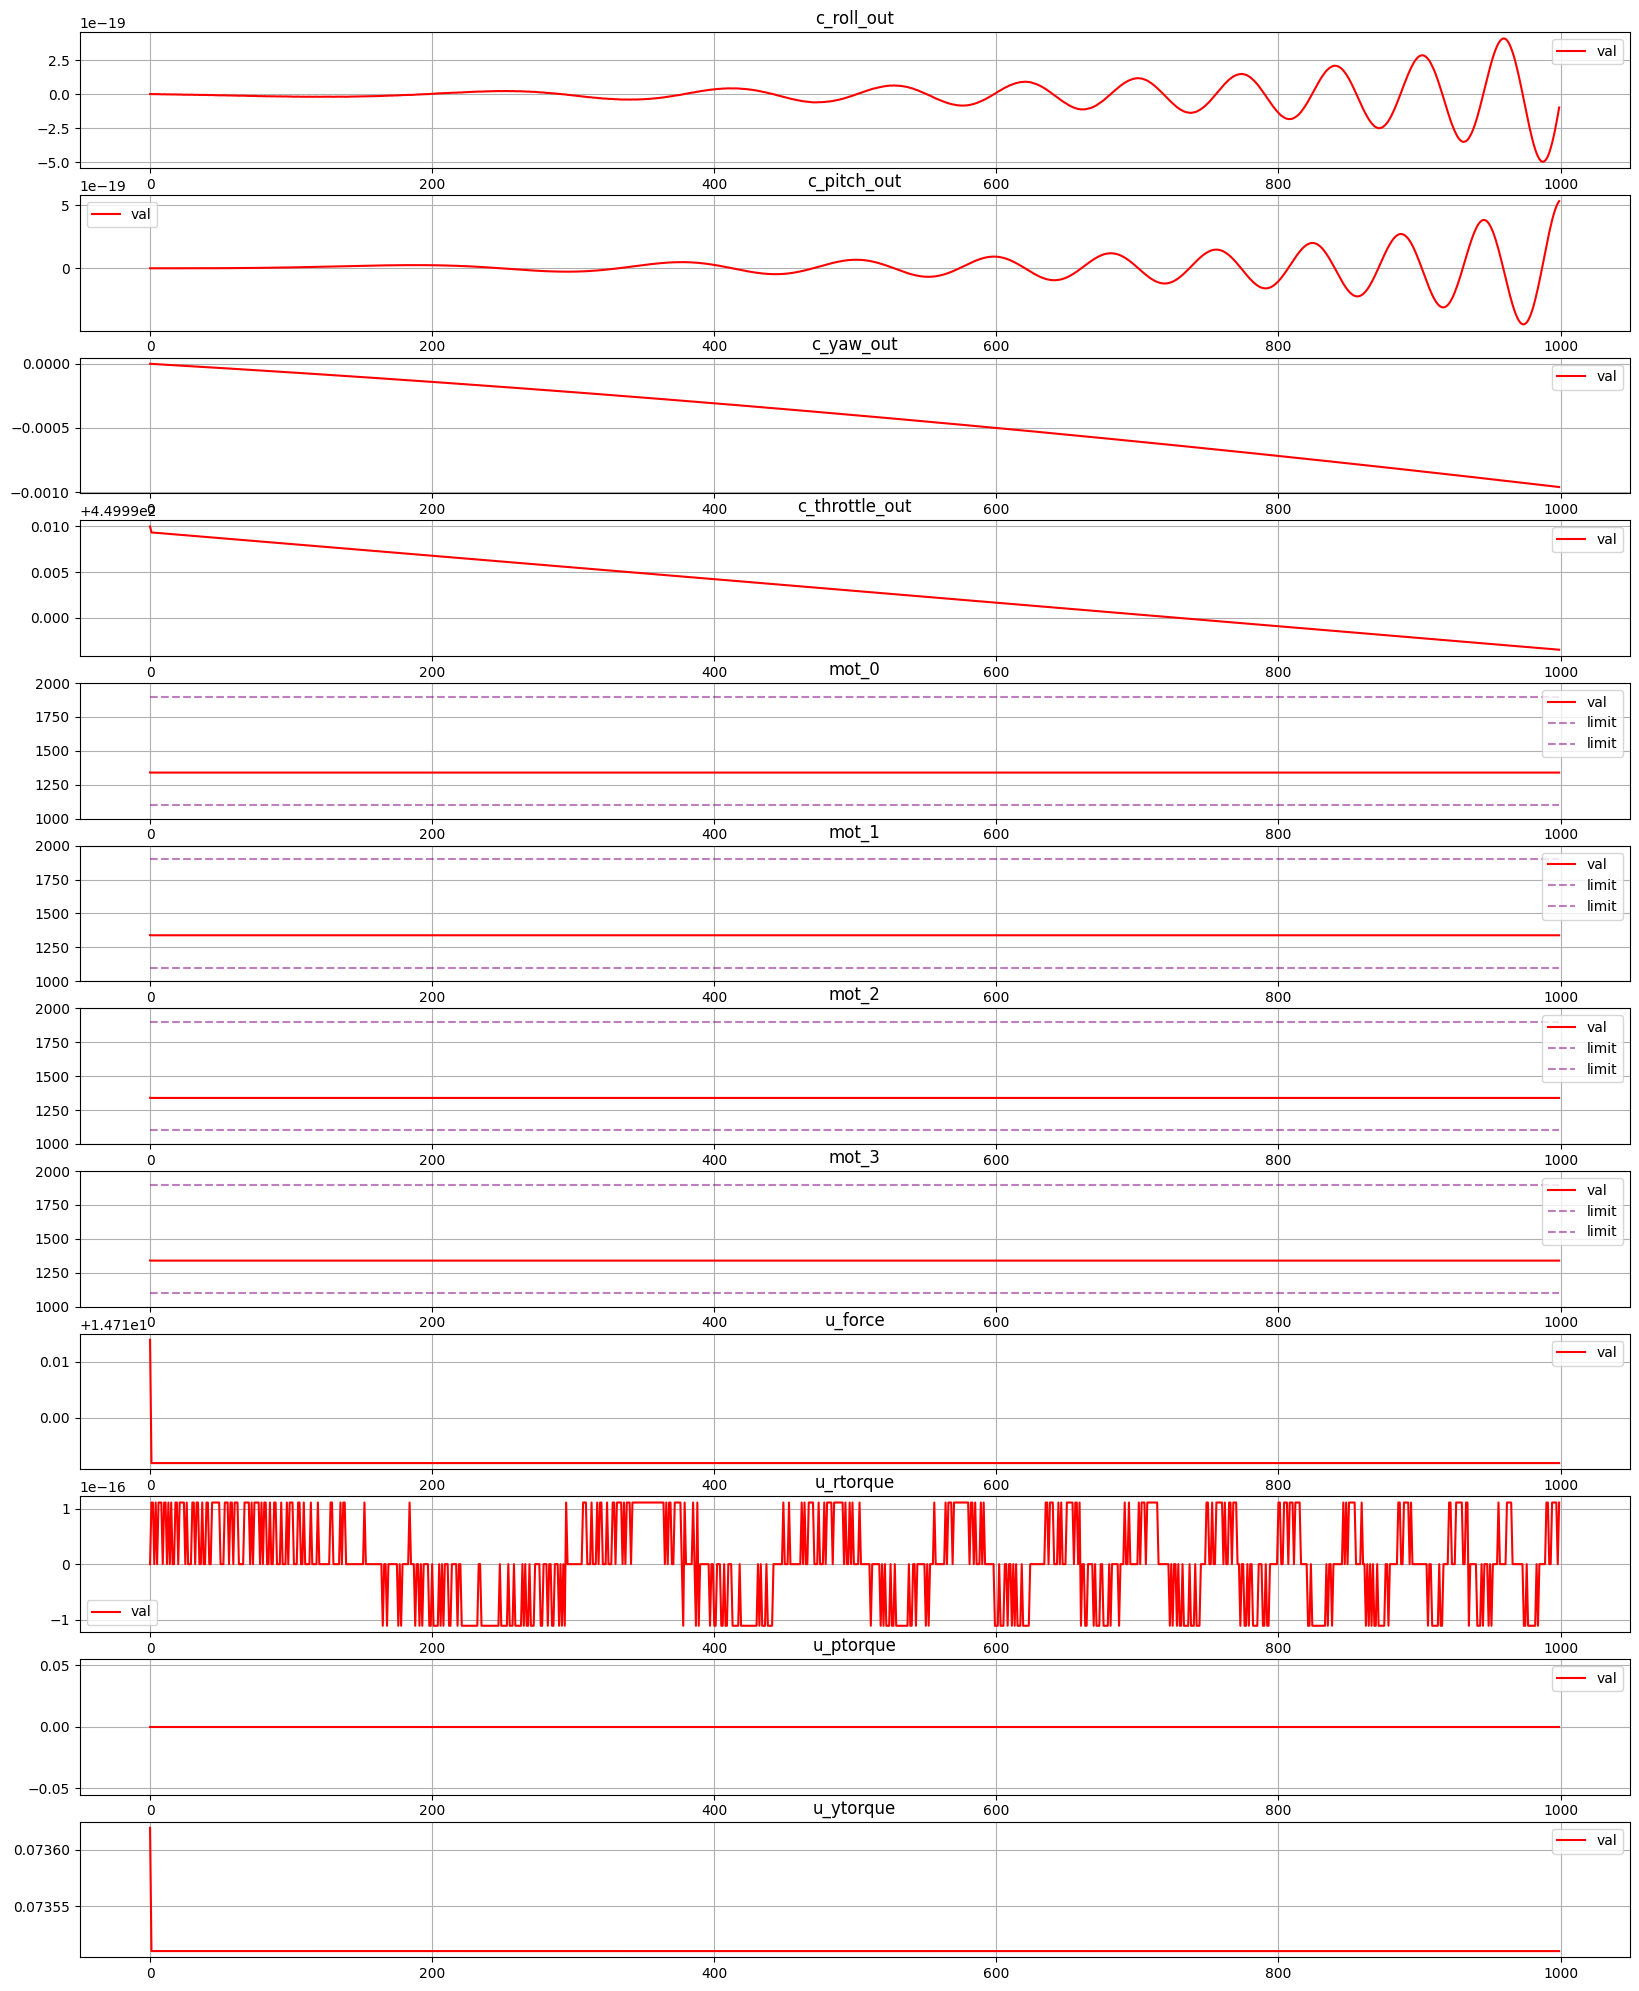

In [170]:
# Visualisation - Intermediate variables
fig = plt.figure(figsize=(20, 25))
var_number = len(ctx.keys())
gs = GridSpec(var_number, 1, figure=fig)

for i, e in enumerate(ctx.keys()):
    ax = fig.add_subplot(gs[i, 0])
    t = range(0,len(ctx[e]))
    ax.plot(t, ctx[e], color='red', label='val')
    ax.set_title(e)
    if e in ['mot_0', 'mot_1', 'mot_2', 'mot_3']:
        ax.set_ylim(1000,2000)
        ax.plot(t, len(ctx[e])*[1100], color='purple', label='limit', linestyle='--', alpha=0.5)
        ax.plot(t, len(ctx[e])*[1900], color='purple', label='limit', linestyle='--', alpha=0.5)
    ax.legend()
    ax.grid()

plt.show()